# Monte Carlo simulation of the Ising model
Guido Raos, Politecnico di Milano, May 2021 (guido.raos@polimi.it)

## Introduction

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) is lattice model. The lattice contains $N$ sites. On each site $i$, we have a "spin" $s_i$. Each spin has only two possible states, as it can either point up ($s_i=+1$) or down ($s_i=-1$). The energy of the system is described by the following expression:
\begin{equation}
 E(s_1, ... , s_N) = -\sum_{i=1}^{N-1} \sum_{j=i+1}^N J_{ij} s_i s_j - F \sum_{i=1}^{N} s_i
\end{equation}
where the first set of terms (double summation) describes the interaction between the spins, and the second one their interaction with some external field $F$ (e.g., a magnetic field in the case of real spins). The inter-site couplings $J_{ij}$ may be either positive or negative, and they can be assumed to decay quickly with the $i$-$j$ distance.

Here we shall consider the situation in which the spins are arranged on a simple square/cubic lattice, and the interaction occur only between nearest neighbours (2 nn in 1D, 4 nn in 2D, 6 nn in 3D, 8 nn in 4D,...). Assuming the $J_{ij}$ parameter is the same for all nn's, we may write:
\begin{equation}
 E(s_1, ... , s_N) = -\frac{J}{2} \sum_{i=1}^N {\sum_{j=1}^N}' s_i s_j - F \sum_{i=1}^{N} s_i
\end{equation}
where the prime in the double summation indicates the restriction to nearest neighbour pairs $(i,j)$ (having terms with $i=j$ in the summation does not do any harm, as this only shifts the total energy by a constant). Note the 1/2 factor in front of the summation, unlike in the previous expression.

The Ising model is can be used to describe a number of phenomena, such as:
* [Magnetism](https://en.wikipedia.org/wiki/Magnetism): both ferromagnetic and antiferromagnetic behaviour can be described, by changing the sign of the inter-site coupling $J$ ($>0$ for ferromagnets, $<0$ for antiferromagnets);
* Two-component sustitutional [alloys](https://en.wikipedia.org/wiki/Alloy) and liquids solutions;
* Morphologies of [bulk heterojunction](https://en.wikipedia.org/wiki/Organic_solar_cell#Bulk_heterojunction) organic solar cells; 
* [Vapour-liquid equilibria](https://en.wikipedia.org/wiki/Vapor%E2%80%93liquid_equilibrium);
* [Spin glasses](https://en.wikipedia.org/wiki/Spin_glass), when the sites have a non-regular arrangements (or the $J_{ij}$ couplings are "random").

The Ising model can be solved exactly in a few cases. Ernst Ising himself solved the 1D case in 1925 (Ising was a student of Wilhelm Lenz, who had first proposed this model in 1920). [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) famously solved the much more difficult [2D case](https://en.wikipedia.org/wiki/Square_lattice_Ising_model) in 1943, showing that it undergoes a transition to a ferromagnetic state below a certain critical temperature (unlike the 1D case). [Kenneth Wilson](https://en.wikipedia.org/wiki/Kenneth_G._Wilson) used it to develop his ideas about critical phenomena, which led to the development of [renormalization group theory](https://en.wikipedia.org/wiki/Renormalization_group): see his article ["Problems in physics with many scales of length"](https://websites.pmc.ucsc.edu/~wrs/Project/2014-summer%20seminar/Renorm/Wilson-many%20scales-Sci%20Am-79.pdf) (Scientific American, 1979) for a popular exposition. The Ising model has been extensively studied also by simulation methods, especially in cases where analytical solutions are not available (e.g., in 3D). Because of its importance, it can probably be considered the "hydrogen molecule" of statistical physics.

In the absence of an external field ($F=0$), the critical temperatures of the ferromagnetic Ising model for a square/cubic lattice are: $kT_C=2.26918531421J$ for the 2D case and $kT_C=4.511528J$ for the 3D case.

In this notebook we are going to apply a variant of the [Metropolis Monte Carlo](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) method to the simulation of the Ising model. The "MC moves" involve the flipping of individual spins.

## The MC code

In [4]:
# Define here some useful functions

# A simple function for writing an xyz file for the Ising model

# IMPORTANT: To be visualized correctly with VMD, file must be read
# from the Tk console with:
# > topo readvarxyz Ising.xyz
# The reason is that, while in an ordinary MD simulation the atoms move but do not
# change their nature (chemical identity), here the atoms do not move but their spin
# (the "chemical identity") changes.

def printIsing(spin, L, filename="Ising.xyz", comment="Ising model", mode="w", scale=2.):
    Nsites = L[0]*L[1]*L[2]
    f = open(filename,mode)
    f.write(str(Nsites) + '\n')
    comment = comment + ": " + str(L[0]) + "x"+ str(L[1]) + "x" + str(L[2])
    f.write(comment + '\n')
    for i in range(L[0]):
        for j in range(L[1]):
            for k in range(L[2]):
                if (spin[i,j,k]>0):
                    atom = 'N '
                else:
                    atom = 'O '
                xyz = str(i*scale).rjust(16) +' '+ \
                      str(j*scale).rjust(16) +' '+ \
                      str(k*scale).rjust(16)
                f.write(atom + xyz + '\n')
    f.close()
    return

# A function to evaluate the energy of a single site within the Ising model
def eSiteIsing(i, j, k, spin, L, pbc, J, F):
    # Energy contribution from interaction with external field is easy...
    energy1 = -F*spin[i][j][k]
    # Before computing spin-spin interactions, build a list of nearest-neighbours
    # for site [i,j,k].
    # NOTE: One could save computing time by constructing this list for all sites,
    # only once at the beginning of the simulation.
    nnsites = []
    w = [i,j,k]
    for d in [0,1,2]:
        if pbc[d]:
            q = w.copy()
            q[d] = (w[d]-1)%L[d]
            nnsites.append(q)
            q = w.copy()
            q[d] = (w[d]+1)%L[d]
            nnsites.append(q)
        else:
            if w[d]>0:
                q = w.copy()
                q[d] = w[d]-1
                nnsites.append(q)
            if w[d]<L[d]-1:
                q = w.copy()
                q[d] = w[d]+1
                nnsites.append(q)
#    print(w, nnsites)
    # Compute energy from spin-spin interactions, by looping over list of nearest-neighbours
    energy2 = 0
    for site in nnsites:
        ii = site[0]
        jj = site[1]
        kk = site[2]
        energy2 += spin[ii][jj][kk]
    energy2 *= -J*spin[i][j][k]
#    print (w, spin[i][j][k], energy1, energy2)
    return energy1, energy2

# A function to evaluate the total energy of Ising model
def eTotalIsing(spin, L, pbc, J, F):
    energy = 0.0
    for i in range(L[0]):
        for j in range(L[1]):
            for k in range(L[2]):
                energy1, energy2 = eSiteIsing(i, j, k, spin, L, pbc, J, F)
                energy += ( energy1 + energy2/2 )
    return energy

# A simple analysis function
def upIsing(spin, L, pbc):
    Nsites = L[0]*L[1]*L[2]
    Nup = 0
    for i in range(L[0]):
        for j in range(L[1]):
            for k in range(L[2]):
                if spin[i][j][k]>0: Nup += 1
    fup = Nup/Nsites
    return fup

*** ISING MODEL MONTE CARLO ***
Lattice size:                  [40, 40, 1] 1600
Periodic Boundary Conditions:  [True, True, False]
J= 1.0    F= 0.0    kT= 2.0
Nmoves=   1600000
Initial probab. for up spins:  0.5
Total energy:  -28.0
Final energy: -2792.0 -2792.0


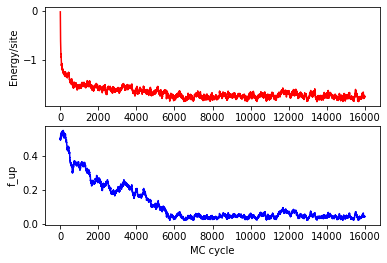

In [5]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

# Define and initialize the random number generator with a "seed"
rng = np.random.default_rng()

# - BEGINNING OF INPUT
L = [40,40,1]              # size of the cubic lattice along x, y and z
pbc = [True, True, True]   # periodic boundary conditions along x, y and z
J = +1.00                    # inter-site coupling
F = +0.00                    # external field
kT = 2.0          # Temperature (in reduced units)
Nsites = L[0]*L[1]*L[2]
Nmoves = Nsites*1000        # Number of MC moves should be proportional to the system size
Nsave = Nmoves/200          # No. of MC moves between writing configuration to xyz file
Nprint = 100                # No. of MC moves between printing thermodynamic info to output file.
# - END OF INPUT

print("*** ISING MODEL MONTE CARLO ***")
print("Lattice size:                 ", L, Nsites)
if (L[0]==1): pbc[0] = False
if (L[1]==1): pbc[1] = False
if (L[2]==1): pbc[2] = False
print("Periodic Boundary Conditions: ", pbc)
print("J=", J, "   F=", F, "   kT=", kT)
print("Nmoves=  ", Nmoves)

# Assign initial spins to the sites.
# We assign them randomly, with probabilities equal to those
# expected for a "gas" of non-interacting spins ($J$=0).
pup = np.exp(+F/kT)      # Boltzmann weight of up configuration
pdown = np.exp(-F/kT)    # Boltzmann weight of down configuration
fup = pup / (pup+pdown)  # Normalized probability, for up configuration
print("Initial probab. for up spins: ", fup)
spin = np.zeros(L)
for i in range(L[0]):
    for j in range(L[1]):
        for k in range(L[2]):
            r = rng.random()
            if r<fup:
                spin[i][j][k] = +1
            else:
                spin[i][j][k] = -1

# Evaluate total energy
energy = eTotalIsing(spin, L, pbc, J, F)
print ("Total energy: ", energy)
comment="Ising energy: "+str(energy)
printIsing(spin, L, comment=comment, mode="w")

energx = energy
thermo = [[],[]]
f = open("Ising.dat", "w")
f.write("         m      energy/site      fup\n")
for m in range(Nmoves):
    site = int( rng.random()*Nsites )  # pick one site at random
    i = site // ( L[1]*L[2] )          # "//" is Python's integer division 
    site -= i*L[1]*L[2]
    j = site // L[2]
    site -= j*L[2]
    k = site                           # now [i,j,k] contains the "coordinates" of the site
    # evaluate energy of site [i,j,k]
    e1, e2 = eSiteIsing(i, j, k, spin, L, pbc, J, F)
    # energy change upon flipping spin of [i,j,k]
    deltaE = -2 * (e1 + e2)
    # Metropolis: accept or reject the spin flip
    if deltaE<0:
        accept = True
        #print(m, "-", deltaE)
    else:
        r = rng.random()
        if np.exp(-deltaE/kT) > r:
            accept = True
            #print(m, "+", deltaE)
        else:
            accept = False
            #print(m, "*", deltaE)
    if accept:
        spin[i][j][k] *= -1            # flip the spin of [i][j][k]
        energx += deltaE               # update the total energy
        
    if m>0 and m%Nsave==0:
        comment="Ising energy: "+str(energx)
        printIsing(spin, L, comment=comment, mode="a")
#        print ("m=", m, "     energx=", energx)
    
    if m%Nprint==0:
        fup = upIsing(spin, L, pbc)
        sss =  ('{0:>10d}  {1:>13.4f}  {2:>8.6f}\n'.format(m, energx, fup)) 
        f.write( sss )
        thermo[0].append(energx/Nsites)
        thermo[1].append(fup)

f.close()
      
energy = eTotalIsing(spin, L, pbc, J, F)
print ("Final energy:", energy, energx)

#plt.plot(thermo[0], 'r-o')
#plt.xlabel('MC cycle')
#plt.ylabel('Energy')

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(thermo[0],'r')
ax1.set_xlabel('MC cycle')
ax1.set_ylabel('Energy/site')
ax2.plot(thermo[1],'b')
ax2.set_xlabel('MC cycle')
ax2.set_ylabel('f_up')
plt.show()

    

## <font color=blue> Further tasks <font>

* Compute the averages, the variances and estimate the errors on the averages for the energy and the magnetization. Make sure that you include in this analysis only the data after a sufficient number of equilibration cycles. Plot these data as a function of temperature or field strength, for a given system. You may also consider the effect of dimensionality, system size, type of boundary conditions, type of spin coupling (sign of $J$), etc.

Suggestions for more challenging problems (they involve some programming):

* Modify the Monte Carlo code so that, instead of flipping one spin at a time, there may be also moves involving an exchange of the spins of two neighoring sites. If we only allow the exchange moves, excluding the spin flips, the number of "up" and "down" spins is rigorously conserved. This might be appropriate, for example, if we wanted to model the phase behaviour of a metallic alloy (e.g., "up"=Cu and "down"=Zn).

* The stardard statistical formulae for the error on averages of data assumes that these data are *uncorrelated*. However, in out MC simulations, successive data points are highly correlated: one configuration is obtained from the previous one by flipping one spin, at most. To be meaningful, we should have included in the previous analysis only data points separated by at least one "decorrelation time" (were "time" stands for "no. of MC moves"). The article ["Error Estimates on Averages of Correlated Data"](https://doi.org/10.1063/1.457480) by Flyvbjerg and Pedersen, who describe a procedure that avoids the evaluation of the autocorrelation functions. This involves the calculations of "block averages" of the data, over blocks of increasing sizes.
* What is the short-range order within the system? How large are the "domains" formed by the up and down spins? To start answering these questions, compute the Warren-Cowley order parameters for a binary mixture (see [here](https://www.sciencedirect.com/science/article/pii/S1359645407002169) or [here](https://arxiv.org/abs/1604.07238v1) for applications to metal alloys, for example):
\begin{equation*}
\alpha_1^{I} = 1 - \frac{ n_{IJ} }{ f_I ( n_{II} + n_{IJ} ) }  \hspace{1cm} (I\neq J)
\end{equation*}
where $f_I$ is the fraction of sites of type $I$ (up or down), $n_{II}$ is the number of nearest-neighbours of $I$ which are also of type $I$, $n_{II}$ is the number of nearest-neighbours of $I$ which are of type $J$ (the subscript "1" indicates that we are computing the parameter for the first coordination shell; it is also possible to define analogous parameters for successive shells).
* Another way of looking at the correlations is to compute and plot the pair distribution functions, $g_{ij}(r)$, among sites of types $i$ and $j$ at a distance $r$. You may write your own code or use the tool within VMD to compute and plot these.

## Further comments

### Comment 1 - Computing the energies
Let us write explicitly the expression for the change in energy when flipping a single spin, on site $i$ (from $s_i$ to $-s_i$). We have:
\begin{equation}
 \Delta E(s_i\rightarrow -s_i) = E(s_1,...,-s_i,...,s_N) - E(s_1,...,s_i,...,s_N) = \\
 = \left\{ -J\sum_{j\ne i}' s_j(-s_i) +Fs_i\right\} -  \left\{ J\sum_{j\ne i}' s_js_i - Fs_i \right\} = \\
 = 2J \sum_{j\ne i}' s_js_i + 2F s_i .
\end{equation}
Let us define the 1-spin and 2-spin components of the energies per site:
\begin{equation}
\epsilon_i^{(1)} = -Fs_i \\
\epsilon_i^{(2)} = -J\sum_{j\ne i}' s_js_i .
\end{equation}
These quantities are computed by `eSiteIsing`. Then the energy change is:
\begin{equation}
 \Delta E(s_i\rightarrow -s_i) = -2 \left\{ \epsilon_i^{(1)}+\epsilon_i^{(2)} \right\} .
\end{equation}
Note that $\epsilon_i^{(1)}$ and $\epsilon_i^{(2)}$ are useful also for computing the total energy, since it can be written:
\begin{equation}
 E(s_1,...,s_N) = \sum_{i=1}^N \left\{ \epsilon_i^{(1)} + \frac{1}{2} \epsilon_i^{(2)} \right\}
\end{equation}
This expression is indeed the one employed in `eTotalIsing`.

### Comment 2 - Numbering of the lattice sites
We have a simple cubic lattice, containg $(L_0,L_1,L_2)$ sites along the three orthogonal directions.  The total number of sites is $N=L_0\times L_1 \times L_2$.  In the main MC code, we have selected one site at random, by generating one random integer $R \in [0, N-1]$. The number $R$ must then be converted into a triplet of integers $(i,j,k)$ (where $i \in [0,L_0-1]$, etc.).  The conversion assumes that sites are numbered in such a way that the rightmost index $k$ changes faster, and the leftmost index changes slower.

The following code illustrates how the $(i,j,k)$ triplet is "packed" into $R$, and how $R$ is "unpacked" to give back the $(i,j,k)$ triplet.

In [ ]:
L = [3,2,4]
R = -1
for ii in range(L[0]):
    for jj in range(L[1]):
        for kk in range(L[2]):
            R += 1                             # R is the site number
            RR = ii*L[1]*L[2] + jj*L[2] + kk   # It could also be computed as follows
            site = R                           # Below we "unpack" R
            i = site // ( L[1]*L[2] )
            site -= i*L[1]*L[2]
            j = site // L[2]
            site -= j*L[2]
            k = site
            # The (ii,jj,kk) triplet coincides with the (i,j,k) triplet
            # Also, R and RR coincide.
            print(ii,jj,kk, "**", R, RR, "**", i,j,k)
                        